In [2]:
#import library
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import math
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

In [3]:
#import data
df_train = pd.read_csv("cs-training.csv")
df_test = pd.read_csv("cs-test.csv")

Data Binning

In [4]:
df_train = df_train.fillna(df_train.median())

The variables needed to be qcut:
- RevolvingUtilizationOfUnsecuredLines
- DebtRatio
- MonthlyIncome
- NumberOfOpenCreditLinesAndLoans
- NumberRealEstateLoansOrLines

The variables needed to be cut:
- age
- NumberOfDependents
- NumberOfTime30-59DaysPastDueNotWorse
- NumberOfTimes90DaysLate
- NumberOfTime60-89DaysPastDueNotWorse

In [5]:
age_bins = [-math.inf, 25, 40, 50, 60, 70, math.inf]
df_train['bin_age'] = pd.cut(df_train['age'],bins=age_bins).astype(str)
dependent_bin = [-math.inf,2,4,6,8,10,math.inf]
df_train['bin_NumberOfDependents'] = pd.cut(df_train['NumberOfDependents'],bins=dependent_bin).astype(str)
dpd_bins = [-math.inf,1,2,3,4,5,6,7,8,9,math.inf]
df_train['bin_NumberOfTimes90DaysLate'] = pd.cut(df_train['NumberOfTimes90DaysLate'],bins=dpd_bins)
df_train['bin_NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime30-59DaysPastDueNotWorse'], bins=dpd_bins)
df_train['bin_NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime60-89DaysPastDueNotWorse'], bins=dpd_bins)


df_train['bin_RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df_train['RevolvingUtilizationOfUnsecuredLines'],q=5,duplicates='drop').astype(str)
df_train['bin_DebtRatio'] = pd.qcut(df_train['DebtRatio'],q=5,duplicates='drop').astype(str)
df_train['bin_MonthlyIncome'] = pd.qcut(df_train['MonthlyIncome'],q=5,duplicates='drop').astype(str)
df_train['bin_NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df_train['NumberOfOpenCreditLinesAndLoans'],q=5,duplicates='drop').astype(str)
df_train['bin_NumberRealEstateLoansOrLines'] = pd.qcut(df_train['NumberRealEstateLoansOrLines'],q=5,duplicates='drop').astype(str)
bin_cols = [c for c in df_train.columns.values if c.startswith('bin_')]

Features choosen based on IV( Information Value)
The formulas are as followed:
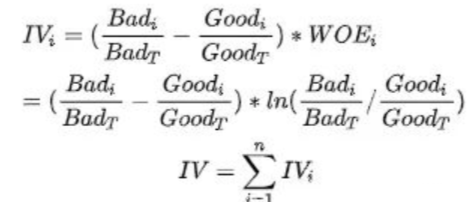
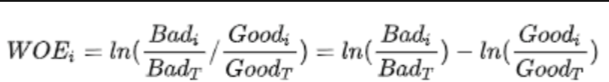

In [6]:
def cal_IV(df, feature, target):
    lst = []
    cols=['Variable', 'Value', 'All', 'Bad']
    for i in range(df[feature].nunique()):
        
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (df[target] == 1)].count()[feature]])
#     print(lst)
    data = pd.DataFrame(lst, columns=cols)
    data = data[data['Bad'] > 0]

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Bad'] / data['Distribution Good'])
    data['IV'] = (data['WoE'] * (data['Distribution Bad'] - data['Distribution Good'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)

    return data['IV'].values[0]

In [7]:
for f in bin_cols:
    print(f)
    print(cal_IV(df_train,f,'SeriousDlqin2yrs'))

bin_age
0.24041120302785982
bin_NumberOfDependents
0.01450836007644442
bin_NumberOfTimes90DaysLate
0.49160685733515563
bin_NumberOfTime30-59DaysPastDueNotWorse
0.492444774570198
bin_NumberOfTime60-89DaysPastDueNotWorse
0.2665587583516951
bin_RevolvingUtilizationOfUnsecuredLines
1.0596188771423887
bin_DebtRatio
0.05948761145809681
bin_MonthlyIncome
0.05623446147714756
bin_NumberOfOpenCreditLinesAndLoans
0.04802315528985505
bin_NumberRealEstateLoansOrLines
0.0120914141106244


Only choose the variables whose VI >1. Those varaibles are as followed:

- bin_RevolvingUtilizationOfUnsecuredLines
- bin_NumberOfTime30-59DaysPastDueNotWorse
- bin_age
- bin_NumberOfTimes90DaysLate
- bin_NumberOfTime60-89DaysPastDueNotWorse

In [8]:
def cal_WOE(df,features,target):
    df_new = df
    for f in features:
        df_woe = df_new.groupby(f).agg({target:['sum','count']})
        df_woe.columns = list(map(''.join, df_woe.columns.values))
        df_woe = df_woe.reset_index()
        df_woe = df_woe.rename(columns = {target+'sum':'bad'})
        df_woe = df_woe.rename(columns = {target+'count':'all'})
        df_woe['good'] = df_woe['all']-df_woe['bad']
        df_woe = df_woe[[f,'good','bad']]
        df_woe['bad_rate'] = df_woe['bad'].mask(df_woe['bad']==0, 1)/df_woe['bad'].sum() # mask 0 to 1 to avoid log(0)
        df_woe['good_rate'] = df_woe['good']/df_woe['good'].sum()
        
        df_woe['woe'] = np.log(df_woe['bad_rate'].divide(df_woe['good_rate'],fill_value=1))
        df_woe.columns = [c if c==f else c+'_'+f for c in list(df_woe.columns.values)]
        df_new = df_new.merge(df_woe,on=f,how='left')
    return df_new
# features choosen based on VI
feature_cols = ['RevolvingUtilizationOfUnsecuredLines','NumberOfTime30-59DaysPastDueNotWorse','age','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse']
bin_cols = ['bin_RevolvingUtilizationOfUnsecuredLines','bin_NumberOfTime30-59DaysPastDueNotWorse','bin_age','bin_NumberOfTimes90DaysLate','bin_NumberOfTime60-89DaysPastDueNotWorse']
df_woe = cal_WOE(df_train,bin_cols,'SeriousDlqin2yrs')
woe_cols = [c for c in list(df_woe.columns.values) if 'woe' in c]
df_bin_to_woe = pd.DataFrame(columns = ['features','bin','woe'])
for f in feature_cols:
    b = 'bin_'+f
    w = 'woe_bin_'+f
    df = df_woe[[w,b]].drop_duplicates()
    df.columns = ['woe','bin']
    df['features'] = f
    df=df[['features','bin','woe']]
    df_bin_to_woe = pd.concat([df_bin_to_woe,df])

C:\Users\marth\AppData\Local\Temp\ipykernel_23776\3614094388.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_woe = df_new.groupby(f).agg({target:['sum','count']})
C:\Users\marth\AppData\Local\Temp\ipykernel_23776\3614094388.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_woe = df_new.groupby(f).agg({target:['sum','count']})
C:\Users\marth\AppData\Local\Temp\ipykernel_23776\3614094388.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default

Logistic Regression Modeling

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_woe[woe_cols], df_woe['SeriousDlqin2yrs'], test_size=0.2, random_state=42)
model = LogisticRegression(random_state=42).fit(X_train,y_train)

In [10]:
model = LogisticRegression(random_state=42).fit(X_train,y_train)

Model Evaluation

Modle evaluation measured by AUC. According to the best practice of industry, over 0.8 is Okay.

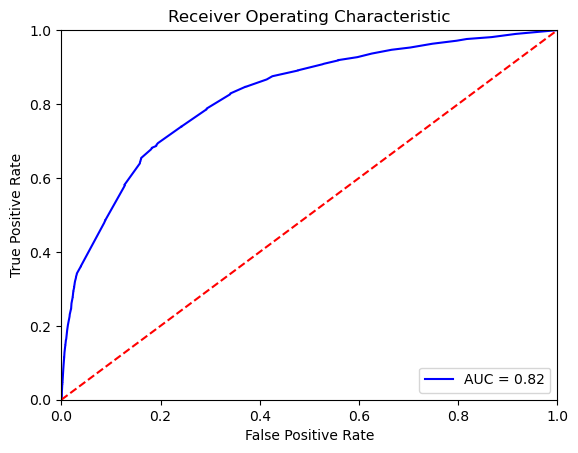

In [11]:
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Credit Score Conversion

The formula is:
Score=A+B⋅ln(odds)

Where:

- Score: The final score in the scorecard.
- A and B: Constants representing the baseline score and the score scaling factor, respectively.
- odds: The odds of default, which is the ratio of the probability of default to the probability of non-default.

In [12]:
A = 650
B =72.13
def generate_scorecard(model_coef,binning_df,features,B):
    lst = []
    cols = ['Variable','Binning','Score']
    coef = model_coef[0]
    for i in range(len(features)):
        f = features[i]
        df = binning_df[binning_df['features']==f]
        for index,row in df.iterrows():
            lst.append([f,row['bin'],int(round(-coef[i]*row['woe']*B))])
    data = pd.DataFrame(lst, columns=cols)
    return data

In [13]:
score_card = generate_scorecard(model.coef_,df_bin_to_woe,feature_cols,B)
score_card.to_excel('dictionary of scorecard.xlsx',index = False)

In [14]:
def str_to_int(s):
    if s == '-inf':
        return -999999999.0
    elif s=='inf':
        return 999999999.0
    else:
        return float(s)
    
def map_value_to_bin(feature_value,feature_to_bin):
    for idx, row in feature_to_bin.iterrows():
        bins = str(row['Binning'])
        left_open = bins[0]=="("
        right_open = bins[-1]==")"
        binnings = bins[1:-1].split(',')
        in_range = True
        # check left bound
        if left_open:
            if feature_value<= str_to_int(binnings[0]):
                in_range = False   
        else:
            if feature_value< str_to_int(binnings[0]):
                in_range = False   
        #check right bound
        if right_open:
            if feature_value>= str_to_int(binnings[1]):
                in_range = False 
        else:
            if feature_value> str_to_int(binnings[1]):
                in_range = False   
        if in_range:
            return row['Binning']
    return null

def map_to_score(df,score_card):
    """Cacluate the final credit score"""
    scored_columns = list(score_card['Variable'].unique())
    score = 0
    for col in scored_columns:
        feature_to_bin = score_card[score_card['Variable']==col]
        feature_value = df[col]
        selected_bin = map_value_to_bin(feature_value,feature_to_bin)
        selected_record_in_scorecard = feature_to_bin[feature_to_bin['Binning'] == selected_bin]
        score += selected_record_in_scorecard['Score'].iloc[0]
    return score
def map_to_score_individual(df,score_card):
    """Gain the credit score of each variable"""
    scored_columns = list(score_card['Variable'].unique())
    scores = {}
    for col in scored_columns:
        feature_to_bin = score_card[score_card['Variable'] == col]
        feature_value = df[col]
        selected_bin = map_value_to_bin(feature_value, feature_to_bin)
        selected_record_in_scorecard = feature_to_bin[feature_to_bin['Binning'] == selected_bin]
        if not selected_record_in_scorecard.empty:
            scores[col] = selected_record_in_scorecard['Score'].iloc[0]
        else:
            scores[col] = None
    return scores

def calculate_score_with_card(df,score_card,A):
    df['score'] = df.apply(map_to_score,args=(score_card,),axis=1)
    df['score'] = df['score']+A
    df['score'] = df['score'].astype(int)
    df['scores']=df.apply(map_to_score_individual,args=(score_card,),axis=1)
    return df

In [15]:
#Take 5 test samples from the good sample and the bad sample respectively
good_sample = df_train[df_train['SeriousDlqin2yrs']==0].sample(10, random_state=1)
good_sample = good_sample[feature_cols]
bad_sample = df_train[df_train['SeriousDlqin2yrs']==1].sample(10, random_state=1)
bad_sample = bad_sample[feature_cols]

In [16]:
#Generate the credit socre of good_sample
calculate_score_with_card(good_sample,score_card,A)

,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,age,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,score,scores
149862,0.000000,0,55,0,0,744,"{'RevolvingUtilizationOfUnsecuredLines': 71, '..."
43190,0.003769,0,39,0,0,725,"{'RevolvingUtilizationOfUnsecuredLines': 71, '..."
90275,0.000000,0,78,0,0,781,"{'RevolvingUtilizationOfUnsecuredLines': 71, '..."
6741,0.013976,0,57,0,0,744,"{'RevolvingUtilizationOfUnsecuredLines': 71, '..."
140108,0.089350,0,39,0,0,702,"{'RevolvingUtilizationOfUnsecuredLines': 48, '..."
74657,0.214893,0,30,0,0,702,"{'RevolvingUtilizationOfUnsecuredLines': 48, '..."
34521,0.415024,0,70,1,0,691,"{'RevolvingUtilizationOfUnsecuredLines': -3, '..."
121578,1.053993,0,46,0,0,594,"{'RevolvingUtilizationOfUnsecuredLines': -68, ..."
90181,0.193201,0,51,0,0,721,"{'RevolvingUtilizationOfUnsecuredLines': 48, '..."
80016,0.010811,0,56,0,0,744,"{'RevolvingUtilizationOfUnsecuredLines': 71, '..."


In [17]:
#Generate the credit socre of bood_sample
calculate_score_with_card(bad_sample,score_card,A)

,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,age,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,score,scores
86741,1.000000,0,49,0,0,594,"{'RevolvingUtilizationOfUnsecuredLines': -68, ..."
137326,0.612609,2,53,0,0,589,"{'RevolvingUtilizationOfUnsecuredLines': -3, '..."
79696,0.608164,5,56,1,0,554,"{'RevolvingUtilizationOfUnsecuredLines': -3, '..."
87970,0.964554,1,30,0,1,586,"{'RevolvingUtilizationOfUnsecuredLines': -68, ..."
120547,0.940120,0,38,1,1,586,"{'RevolvingUtilizationOfUnsecuredLines': -68, ..."
66181,0.943814,1,41,0,0,594,"{'RevolvingUtilizationOfUnsecuredLines': -68, ..."
100137,0.015025,0,56,0,0,744,"{'RevolvingUtilizationOfUnsecuredLines': 71, '..."
16444,0.350671,0,58,0,0,670,"{'RevolvingUtilizationOfUnsecuredLines': -3, '..."
139137,0.720492,0,36,0,0,586,"{'RevolvingUtilizationOfUnsecuredLines': -68, ..."
81418,0.503930,0,30,0,0,651,"{'RevolvingUtilizationOfUnsecuredLines': -3, '..."


In [18]:
#wrangling data and generate the score for each variable in good_sample
good_sample=good_sample.reset_index()
good_sample.rename(columns={'index':'userid'}, inplace=True)
dfscore=good_sample[['userid','score','scores']]
df = dfscore
# Extract unique keys
unique_keys = set().union(*(d.keys() for d in df['scores']))
# Create new columns for each unique key and fill them with values
for key in unique_keys:
    df[key] = [value.get(key) for value in df['scores']]

# Drop the original 'score' column
df.drop(columns=['scores'], inplace=True)
df.drop(columns=['age'], inplace=True)
df.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'Score_overdue_30-59Days'},inplace = True)
df.rename(columns={'NumberOfTime60-89DaysPastDueNotWorse':'Score_overdue_60-89Days'},inplace = True)
df.rename(columns={'NumberOfTimes90DaysLate':'Score_overdue_more_than_90Days'},inplace = True)
df.rename(columns={'RevolvingUtilizationOfUnsecuredLines':'Score_Utilization_of_Creditcard'},inplace = True)
df.to_excel('test_good_example.xlsx',index = False)

C:\Users\marth\AppData\Local\Temp\ipykernel_23776\2503407262.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = [value.get(key) for value in df['scores']]
C:\Users\marth\AppData\Local\Temp\ipykernel_23776\2503407262.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = [value.get(key) for value in df['scores']]
C:\Users\marth\AppData\Local\Temp\ipykernel_23776\2503407262.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [19]:
#wrangling data and generate the score for each variable in bad_sample
bad_sample=bad_sample.reset_index()
bad_sample.rename(columns={'index':'userid'}, inplace=True)
dfscore=bad_sample[['userid','score','scores']]
df = dfscore

# Extract unique keys
unique_keys = set().union(*(d.keys() for d in df['scores']))

# Create new columns for each unique key and fill them with values
for key in unique_keys:
    df[key] = [value.get(key) for value in df['scores']]

# Drop the original 'score' column
df.drop(columns=['scores'], inplace=True)
df.drop(columns=['age'], inplace=True)
df.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'Score_overdue_30-59Days'},inplace = True)
df.rename(columns={'NumberOfTime60-89DaysPastDueNotWorse':'Score_overdue_60-89Days'},inplace = True)
df.rename(columns={'NumberOfTimes90DaysLate':'Score_overdue_more_than_90Days'},inplace = True)
df.rename(columns={'RevolvingUtilizationOfUnsecuredLines':'Score_Utilization_of_Creditcard'},inplace = True)
df.to_excel('test_bad_sample.xlsx',index = False)

C:\Users\marth\AppData\Local\Temp\ipykernel_23776\149456319.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = [value.get(key) for value in df['scores']]
C:\Users\marth\AppData\Local\Temp\ipykernel_23776\149456319.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = [value.get(key) for value in df['scores']]
C:\Users\marth\AppData\Local\Temp\ipykernel_23776\149456319.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in